Importar Librerías

In [14]:
import pandas as pd
import numpy as np
import h5py
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Definir variables globales

In [26]:
ancho = 160
alto = 129
canales = 3
pixeles = ancho*alto*canales
cantidadClases = 5
clases = ['Banano', 'Granada', 'Kiwi', 'Mango', 'Pitaya']
batchSize = 64

Definir Función Auxiliar

In [3]:
def view_classify(img, ps):
  ps = ps.data.numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(16,13), ncols=2)
  ax1.imshow(img.numpy().transpose((1, 2, 0)))
  ax1.axis('off')
  ax2.barh(np.arange(cantidadClases), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(cantidadClases))
  ax2.set_yticklabels(clases, size='medium');
  ax2.set_title('Probabilidad de las Clases')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

Importar dataset

In [4]:
#Se transforma a la mitad del tamaño por restricciones de memoria
transform = transforms.Compose([transforms.Resize((ancho, alto)),transforms.ToTensor(),])
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Train')
trainset = ImageFolder(root=dataset_path, transform=transform)
trainloader = DataLoader(trainset, batch_size=batchSize, shuffle=True)

La función de activación será relu para las capas ocultas y softmax para la capa final: https://www.mdpi.com/2079-9292/12/14/3132

Definir la estructura de la red y el forward

In [5]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(pixeles, 20640)
    self.fc2 = nn.Linear(20640, 6880)
    self.fc3 = nn.Linear(6880, 2293)
    self.fc4 = nn.Linear(2293, 764)
    self.fc5 = nn.Linear(764, 254)
    self.fc6 = nn.Linear(254, 84)
    self.fc7 = nn.Linear(84, cantidadClases)
      
  def forward(self, x):
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = F.log_softmax(self.fc7(x), dim=1)
    
    return x

model = Network()

Inicializar pesos y bias

In [6]:
model.fc1.bias.data.fill_(0)
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 4.5370e-03, -5.2119e-03, -3.6337e-03,  ...,  6.0602e-03,
          6.8226e-03,  2.6998e-03],
        [-2.8508e-03, -1.1140e-02,  1.9235e-03,  ...,  1.0863e-02,
         -3.8596e-03, -1.5572e-02],
        [-1.0521e-02,  1.4646e-02, -5.1100e-03,  ...,  3.8070e-03,
          1.4114e-04, -3.6965e-04],
        ...,
        [ 3.1091e-03,  1.1184e-02,  8.7583e-03,  ..., -5.7045e-03,
          1.8122e-02,  6.0132e-03],
        [ 2.0907e-02, -7.8557e-03,  2.7165e-04,  ..., -4.7860e-03,
         -1.2738e-03, -5.1275e-03],
        [-8.4981e-04, -1.3321e-02, -4.3346e-03,  ..., -1.3083e-05,
          3.8339e-03, -2.5244e-03]])

Construir modelo con capas secuenciales

In [7]:
input_size = pixeles
hidden_sizes = [20640, 6880, 2293, 764, 254, 84]
output_size = cantidadClases

model = nn.Sequential(OrderedDict([
  ('capa1',nn.Linear(input_size, hidden_sizes[0])),
  ('actv1',nn.ReLU()),
  ('capa2',nn.Linear(hidden_sizes[0], hidden_sizes[1])),
  ('actv2',nn.ReLU()),
  ('capa3',nn.Linear(hidden_sizes[1], hidden_sizes[2])),
  ('actv3',nn.ReLU()),
  ('capa4',nn.Linear(hidden_sizes[2], hidden_sizes[3])),
  ('actv4',nn.ReLU()),
  ('capa5',nn.Linear(hidden_sizes[3], hidden_sizes[4])),
  ('actv5',nn.ReLU()),
  ('capa6',nn.Linear(hidden_sizes[4], hidden_sizes[5])),
  ('actv6',nn.ReLU()),
  ('capa7',nn.Linear(hidden_sizes[5], output_size)),
  ('actv7',nn.Softmax(dim=1))
]))

Realizar forward

In [8]:
images,labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
ps = model.forward(images[0,:].unsqueeze(0))

Calcular las pérdidas, nuestra predicción de error

In [12]:
criterion = nn.NLLLoss()

images,labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
logps = model(images)
loss = criterion(logps, labels)

print(loss)

tensor(-0.1988, grad_fn=<NllLossBackward0>)


Autograd

In [13]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 3.8679e-07,  4.0201e-07,  4.1555e-07,  ...,  1.7983e-06,
          1.7784e-06,  1.6695e-06],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.8711e-08, -3.8711e-08, -3.6292e-08,  ..., -1.0041e-07,
         -1.1008e-07, -7.9237e-08],
        ...,
        [-2.2655e-08, -2.8573e-08, -5.9480e-08,  ..., -3.3774e-08,
         -1.7282e-08, -1.3967e-08],
        [-3.2156e-07, -3.2101e-07, -2.9892e-07,  ...,  2.1926e-08,
          2.8643e-08, -4.9597e-09],
        [ 1.5570e-07,  1.6265e-07,  1.2603e-07,  ..., -1.2989e-07,
         -1.3460e-07, -1.7025e-07]])


Iniciar entrenamiento

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(batchSize, pixeles)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 2.8841e-03,  1.5519e-03, -2.4851e-03,  ...,  1.6001e-03,
          3.6208e-03, -1.3731e-03],
        [ 3.3336e-04, -3.9658e-03, -1.7802e-03,  ...,  1.5032e-03,
         -1.6863e-03,  3.2621e-03],
        [-1.5449e-03,  2.0840e-03,  1.6935e-03,  ..., -3.6378e-05,
          2.0846e-03,  8.0982e-04],
        ...,
        [-1.8436e-03, -3.5057e-04, -2.6319e-03,  ...,  1.4359e-03,
          1.7810e-03, -8.9858e-04],
        [-2.6749e-03, -1.2566e-04,  1.8484e-03,  ...,  1.8438e-03,
         -2.2731e-03, -1.1085e-03],
        [ 8.7050e-05, -5.1812e-04, -8.4468e-04,  ..., -2.1213e-03,
         -1.2734e-03,  4.0826e-04]], requires_grad=True)
Gradient - tensor([[-1.6416e-07, -1.4606e-07, -1.3557e-07,  ...,  1.0912e-06,
          1.0181e-06,  9.1866e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.7165e-08, -1.6977e-08, -1.7634e-08,  ..., -3.6418e-08,
         -3.9259e-08, -

In [21]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 2.8841e-03,  1.5519e-03, -2.4851e-03,  ...,  1.6001e-03,
          3.6207e-03, -1.3732e-03],
        [ 3.3336e-04, -3.9658e-03, -1.7802e-03,  ...,  1.5032e-03,
         -1.6863e-03,  3.2621e-03],
        [-1.5449e-03,  2.0840e-03,  1.6935e-03,  ..., -3.6378e-05,
          2.0846e-03,  8.0982e-04],
        ...,
        [-1.8436e-03, -3.5057e-04, -2.6319e-03,  ...,  1.4359e-03,
          1.7810e-03, -8.9860e-04],
        [-2.6749e-03, -1.2565e-04,  1.8484e-03,  ...,  1.8438e-03,
         -2.2731e-03, -1.1085e-03],
        [ 8.7048e-05, -5.1812e-04, -8.4468e-04,  ..., -2.1213e-03,
         -1.2734e-03,  4.0826e-04]], requires_grad=True)


Entrenamiento parte 2

In [22]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: -0.20000348631608283
Training loss: -0.2000760615377103
Training loss: -0.20010406056703148
Training loss: -0.20016930593272386
Training loss: -0.20021159568075406


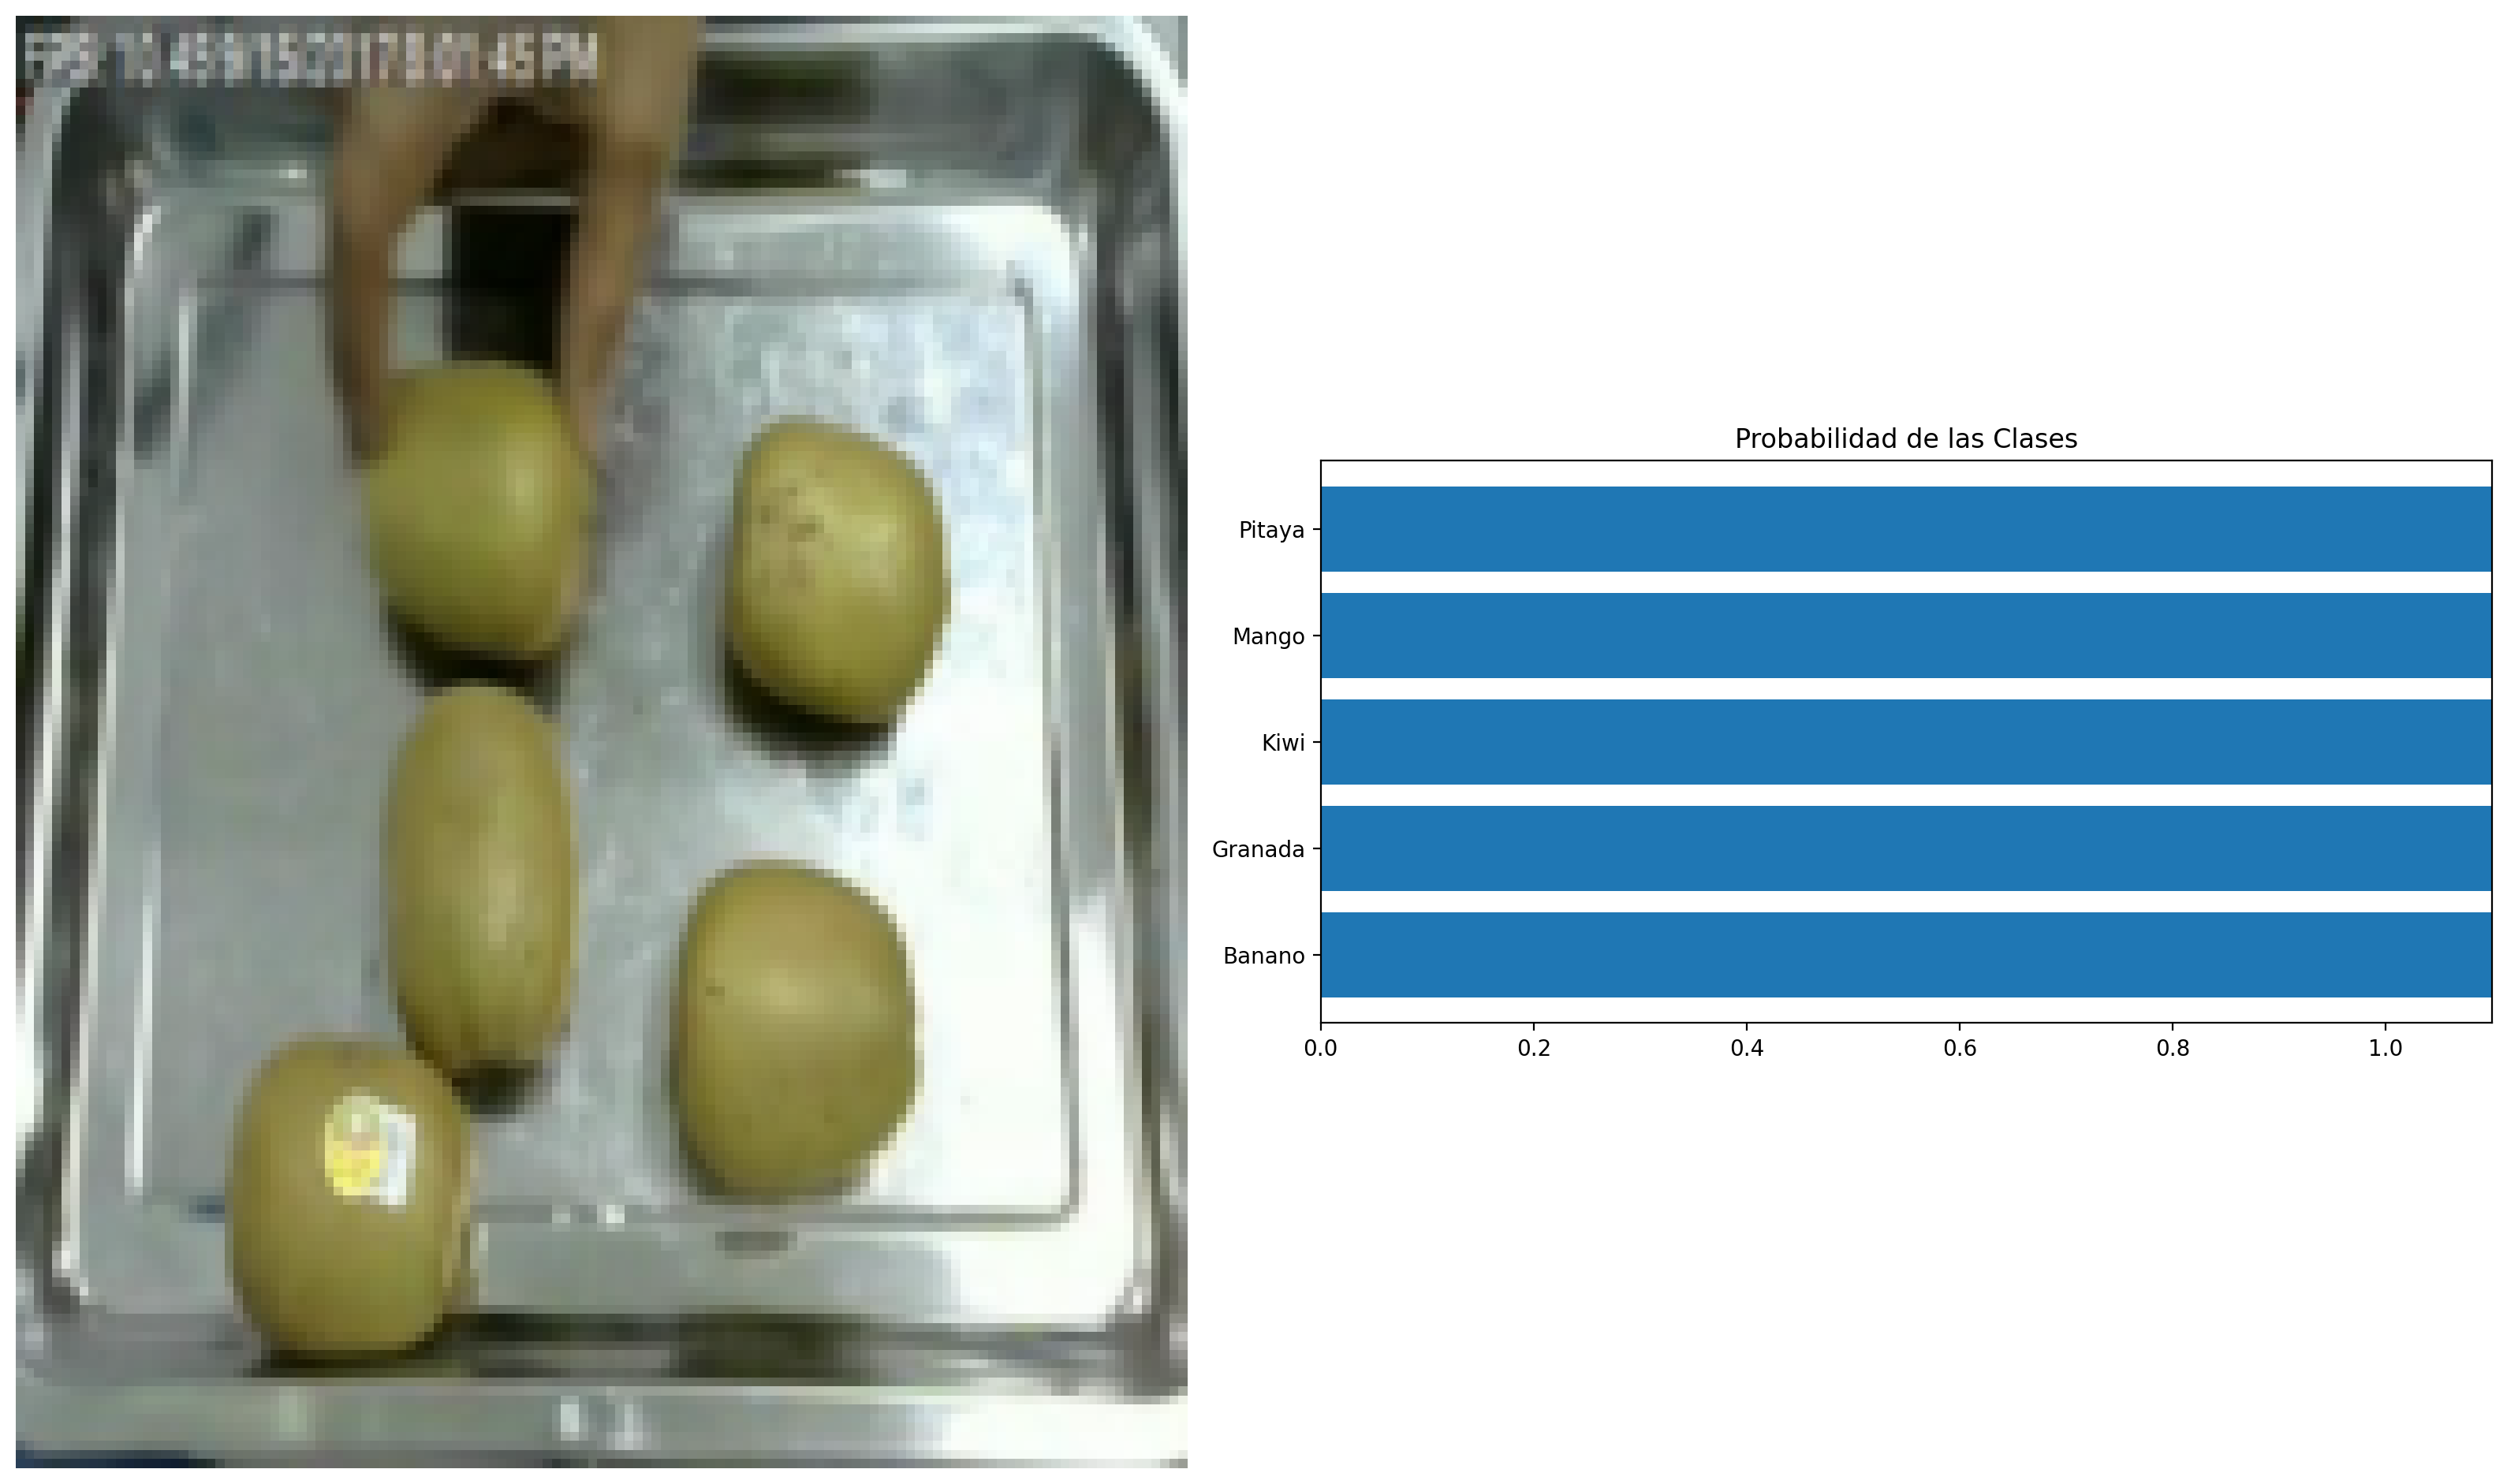

In [24]:
images, labels = next(iter(trainloader))

img = images[0].view(1, pixeles)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(canales, ancho, alto), ps)

**Guía 4**

Importar dataset de prueba

In [27]:
#Se transforma a la mitad del tamaño por restricciones de memoria
transform = transforms.Compose([transforms.Resize((ancho, 129)),transforms.ToTensor(),])
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Test')
testset = ImageFolder(root=dataset_path, transform=transform)
testloader = DataLoader(testset, batch_size=batchSize, shuffle=True)

'images, labels = next(iter(trainloader))\n\nimg = images[0].view(1, pixeles)\n# Turn off gradients to speed up this part\nwith torch.no_grad():\n    logps = model(img)\n\n# Output of the network are log-probabilities, need to take exponential for probabilities\nps = torch.exp(logps)\nview_classify(img.view(canales, ancho, alto), ps)'

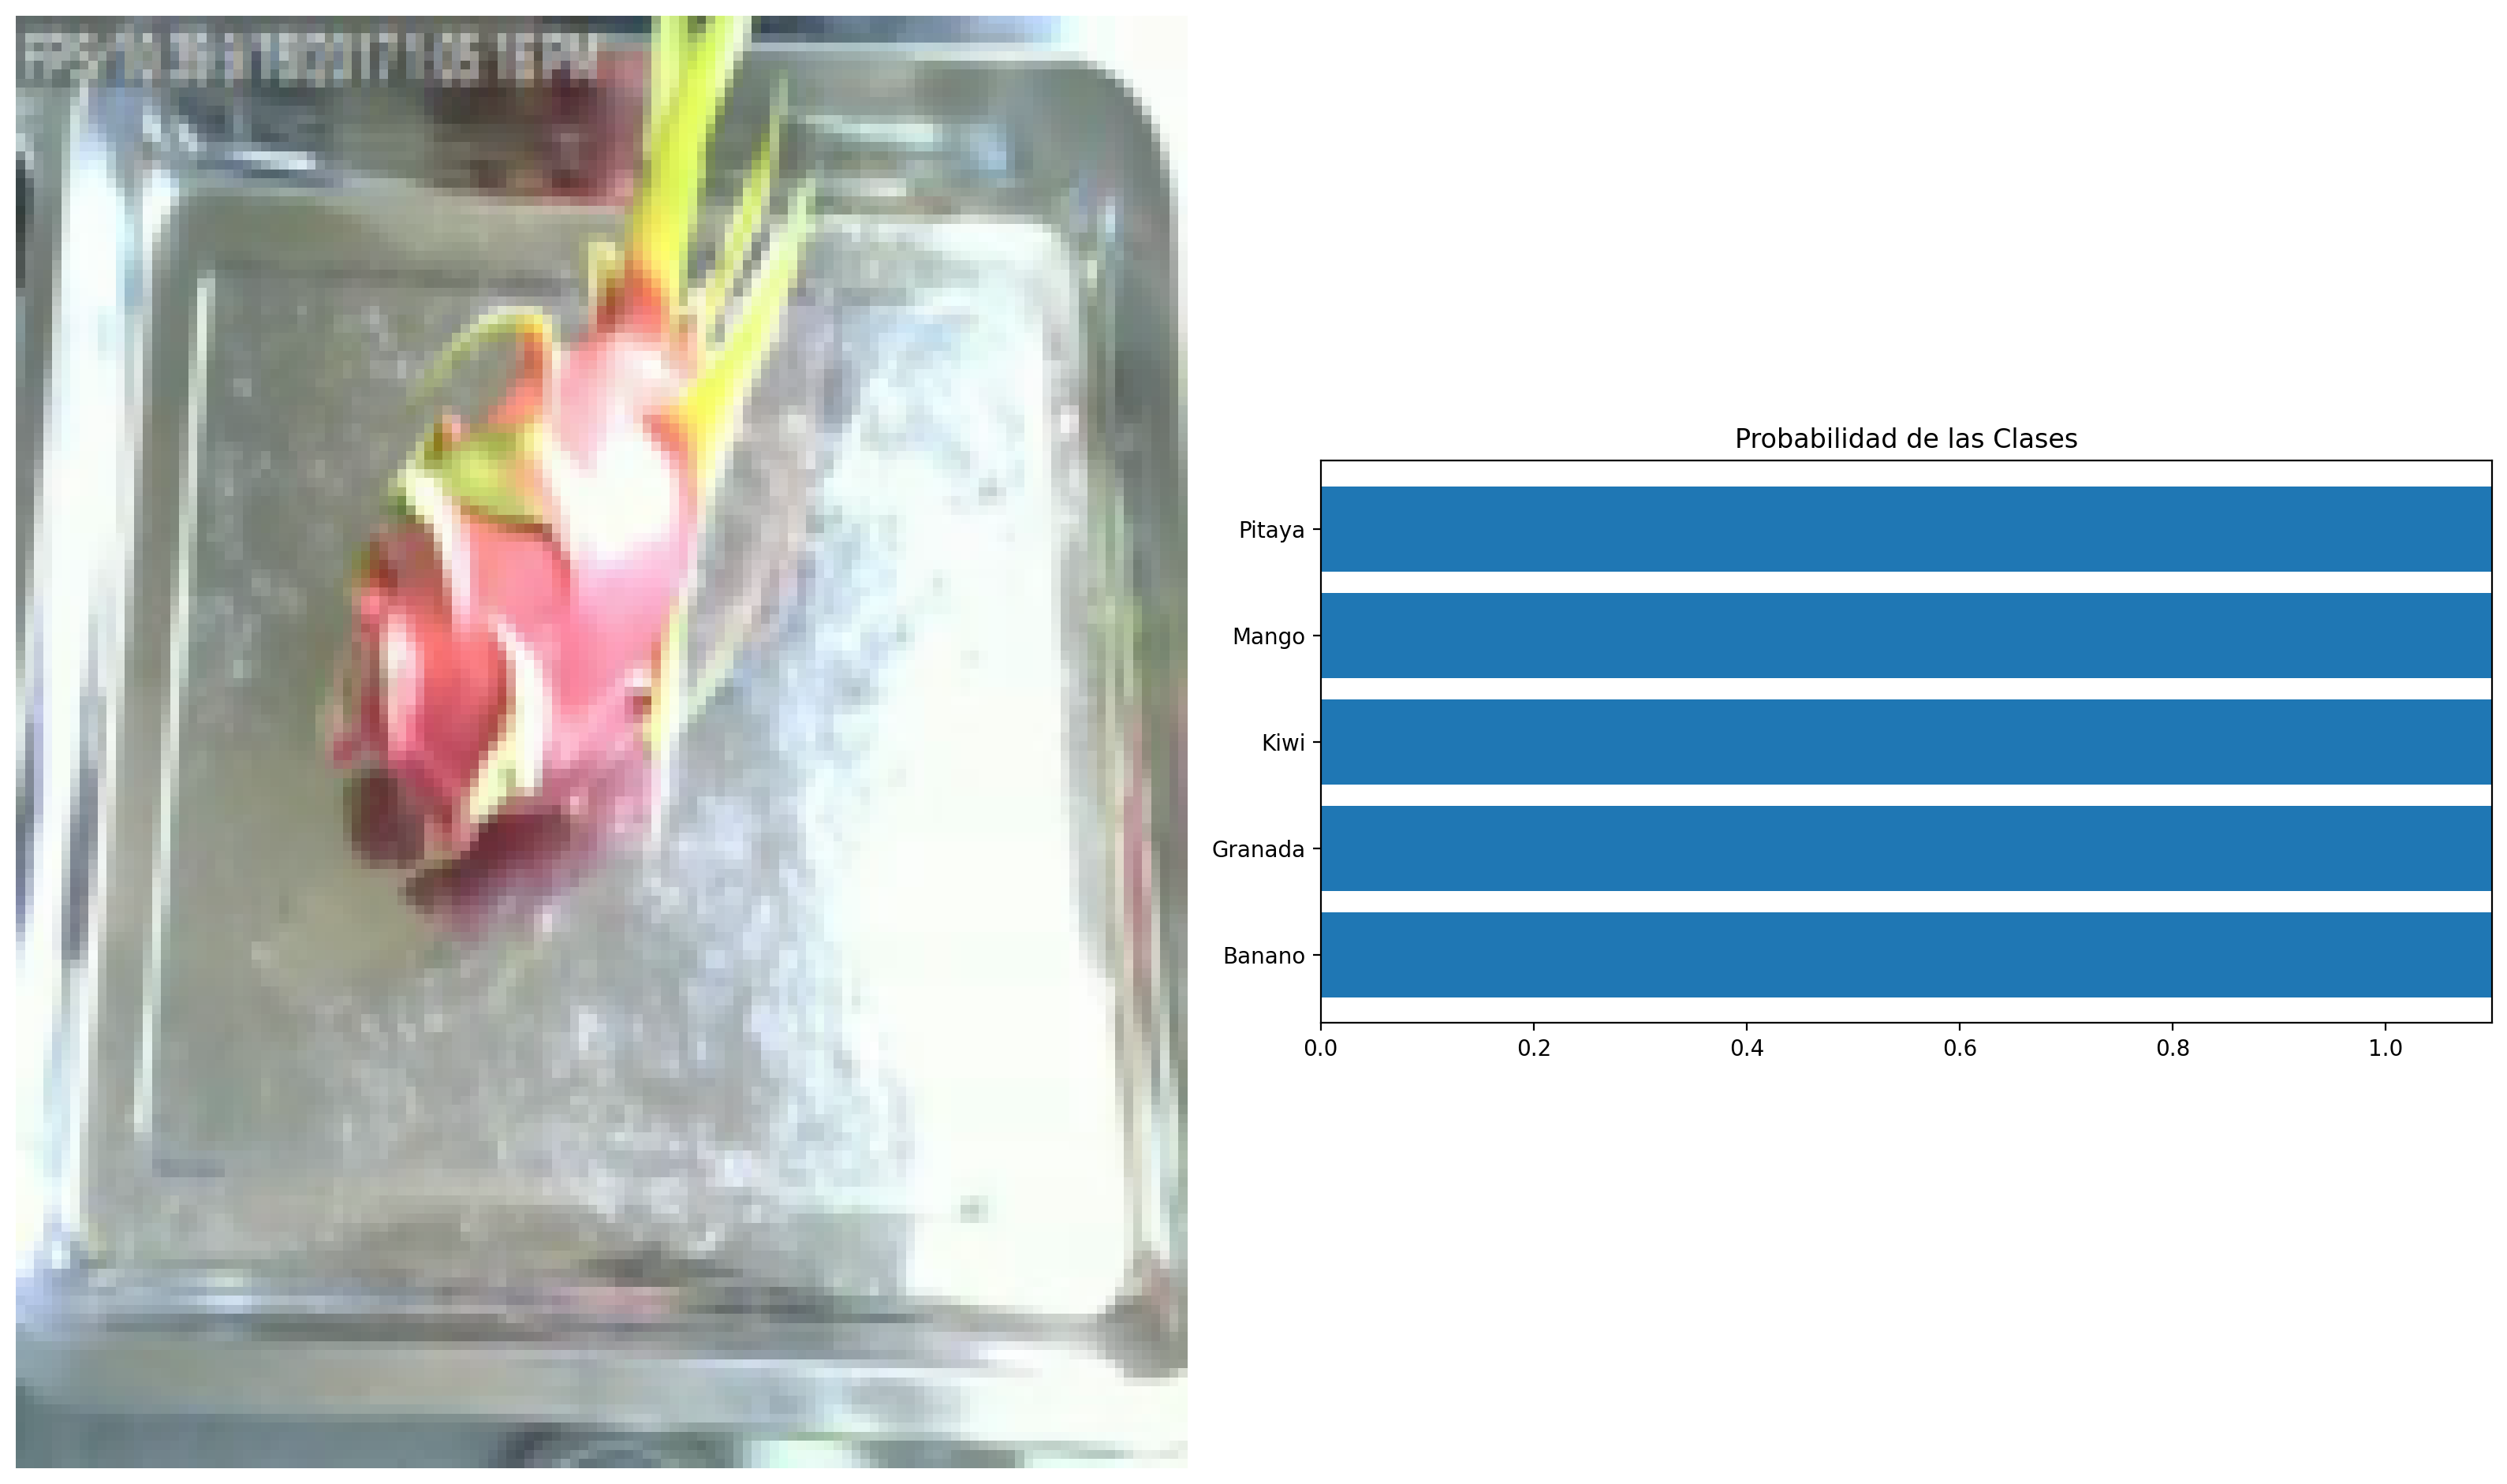

In [31]:
dataiter = iter(testloader)
images, labels = next(iter(testloader))
img = images[1].view(1, pixeles)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
view_classify(img.view(canales, ancho, alto), ps)